### Reproduce Figure 5 (Minimal Plane)

In [1]:
import matplotlib.pyplot as plt
import nvdiffrast.torch as dr
import torch
from tqdm import tqdm

from diffshadow import *
from diffshadow.simple_renderer import SimpleRenderer, create_plane_mesh, DirectionalLight, Camera
from utilities import *

device         = torch.device('cuda:0')
render_context = dr.RasterizeGLContext(device=device)
renderer       = SimpleRenderer(render_context)
resolution     = (512, 512)

Set up the scene and render a reference image

c:\Users\mworchel\Miniconda3\envs\diffshadow_dev\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


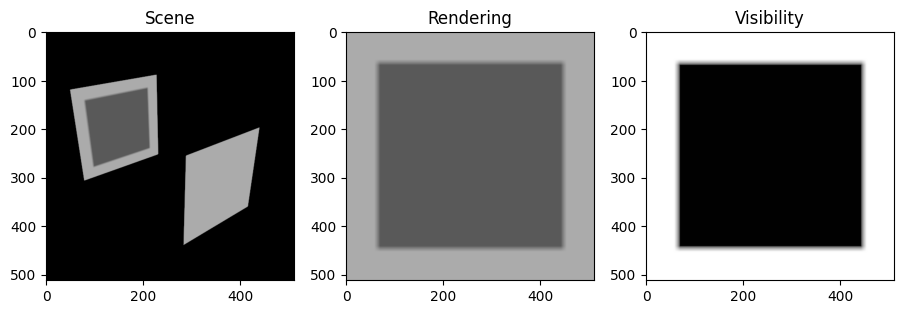

In [2]:

receiver = create_plane_mesh([0, 0, -2], [0, 0, 1], size=1,    device=device)
caster   = create_plane_mesh([0, 0,  1], [0, 0, 1], size=0.75, device=device)

light = DirectionalLight(torch.tensor([0, 0, 1], dtype=torch.float32, device=device), near=0.1, far=20)

camera = Camera(
    projection_matrix=create_orthographic_projection_matrix(size=1.0, near=0.1, far=10.0, device=device),
    view_matrix=create_lookat_matrix(eye=[0.0, 0.0, 0.0], focus=[0.0, 0.0, -2.0], up=[0.0, 1.0, 0.0]).to(device),
)

# Debug camera for a high-level scene overview
camera_debug = Camera(
    projection_matrix=create_perspective_projection_matrix(fovy=45, near=0.1, far=10.0, device=device),
    view_matrix=create_lookat_matrix(eye=[-3., 2.5, 3.5], focus=[0.0, 0.0, -0.25], up=[0.0, 1.0, 0.0]).to(device),
) 

img_ref, visibilities_ref = renderer.render([receiver, caster], [light], camera, resolution=resolution, return_visibility=True)
img_debug_ref             = renderer.render([receiver, caster], [light], camera_debug, resolution=resolution)

plot(img_debug_ref, img_ref, visibilities_ref[0], titles=["Scene", "Rendering", "Visibility"])

Perturb a single vertex of the shadow caster by scaling its xy components

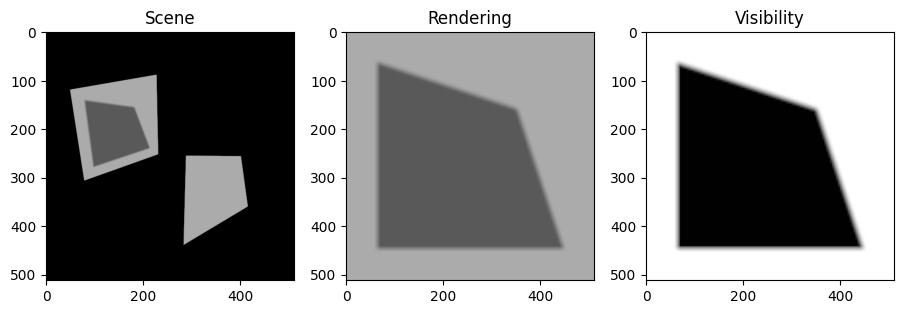

In [3]:
v3_perturbed         = caster.vertices[3:4].clone()
v3_perturbed[0, :2] *= 1/2

# Combine the original vertices with the perturbed vertex to get a new caster
v_perturbed      = torch.cat([caster.vertices[:3], v3_perturbed])
caster_perturbed = caster.with_vertices(v_perturbed)

img_perturbed, visibilities_perturbed = renderer.render([receiver, caster_perturbed], [light], camera, resolution=resolution, return_visibility=True)
img_debug_perturbed                   = renderer.render([receiver, caster_perturbed], [light], camera_debug, resolution=resolution)

plot(img_debug_perturbed, img_perturbed, visibilities_perturbed[0], titles=["Scene", "Rendering", "Visibility"])

Set up the optimization of the single vertex position

In [4]:
def optimize_caster(antialias: bool, custom_camera=None, custom_visibility_ref=None):
    v3_opt = v3_perturbed.clone()
    v3_opt.requires_grad = True

    optimizer = torch.optim.Adam([v3_opt], lr=0.005)

    losses       = []
    visibilities = []
    progress_bar = tqdm(range(150))
    for iteration in progress_bar:
        v_opt      = torch.cat([caster.vertices[:3], v3_opt])
        caster_opt = caster.with_vertices(v_opt)

        img_opt, visibilities_opt = renderer.render([receiver, caster_opt], [light], camera if custom_camera is None else custom_camera, resolution=resolution, return_visibility=True, use_shadow_antialiasing=antialias)

        visibility_ref  = visibilities_ref[0] if custom_visibility_ref is None else custom_visibility_ref
        visibility_diff = visibilities_opt[0]-visibility_ref
        loss = torch.mean(visibility_diff**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses       += [loss.item()]
        visibilities += [visibilities_opt[0].detach()]
        progress_bar.set_postfix({'loss': f"{loss.item():0.7f}"})

    return caster_opt, losses, visibilities

100%|██████████| 150/150 [00:01<00:00, 130.59it/s, loss=0.2057416]


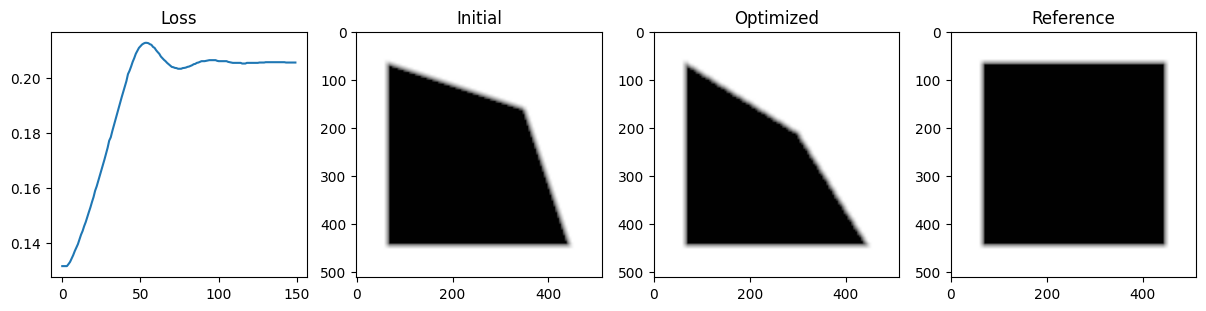

In [5]:
# Optimize without shadow map anti-aliasing (fails)
caster_opt, losses, visibilities = optimize_caster(antialias=False)
plot(losses, visibilities[0], visibilities[-1], visibilities_ref[0], titles=["Loss", "Initial", "Optimized", "Reference"])

100%|██████████| 150/150 [00:01<00:00, 126.69it/s, loss=0.0000007]


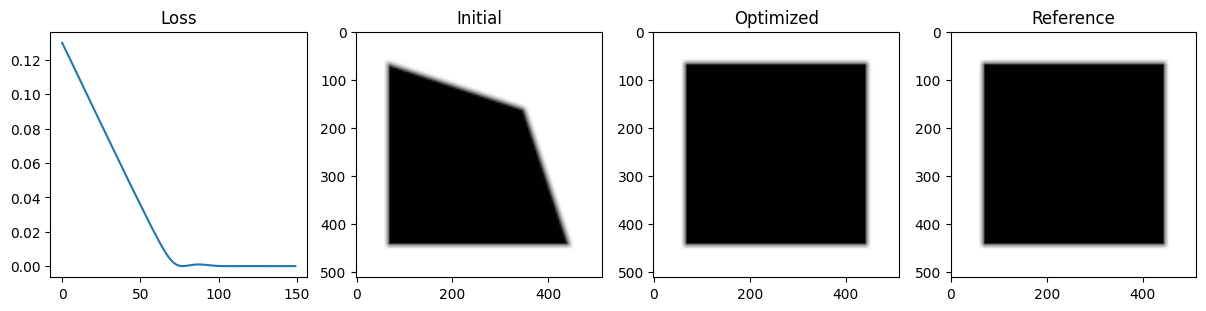

In [6]:
# Optimize with shadow map anti-aliasing (succeeds)
caster_opt, losses, visibilities = optimize_caster(antialias=True)
plot(losses, visibilities[0], visibilities[-1], visibilities_ref[0], titles=["Loss", "Initial", "Optimized", "Reference"])

Run the same optimization with non co-located camera and light

100%|██████████| 150/150 [00:01<00:00, 132.99it/s, loss=0.1482519]


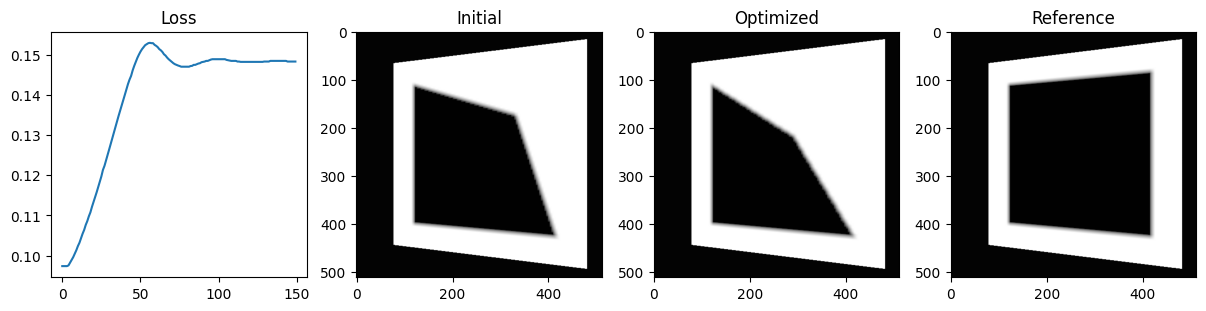

100%|██████████| 150/150 [00:01<00:00, 125.47it/s, loss=0.0000000]


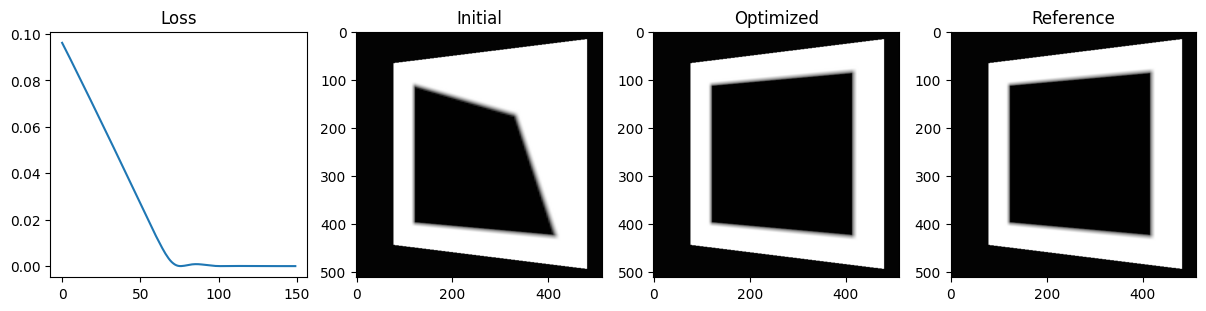

In [7]:
camera_perspective = Camera(
    projection_matrix=create_perspective_projection_matrix(fovy=45, near=0.1, far=10.0, device=device),
    view_matrix=create_lookat_matrix(eye=[1.0, 0.0, 0.75], focus=[0.0, 0.0, -2.0], up=[0.0, 1.0, 0.0]).to(device),
)

_, visibilities_perspective_ref = renderer.render([receiver, caster], [light], camera_perspective, resolution=resolution, return_visibility=True)

caster_opt, losses, visibilities = optimize_caster(antialias=False, custom_camera=camera_perspective, custom_visibility_ref=visibilities_perspective_ref[0])
plot(losses, visibilities[0], visibilities[-1], visibilities_perspective_ref[0], titles=["Loss", "Initial", "Optimized", "Reference"])

caster_opt, losses, visibilities = optimize_caster(antialias=True, custom_camera=camera_perspective, custom_visibility_ref=visibilities_perspective_ref[0])
plot(losses, visibilities[0], visibilities[-1], visibilities_perspective_ref[0], titles=["Loss", "Initial", "Optimized", "Reference"])